In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import Corpus, TensorDecomposer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import defaultdict
from convokit import BoWTransformer, VectorClassifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
from collections import Counter
from itertools import product
import pandas as pd

from convokit import BoWTransformer, VectorClassifier, Classifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
corpus = Corpus(filename='Wikipedia-Disputes-Corpus')

In [4]:
analyzer = SentimentIntensityAnalyzer()

In [5]:
for utt in corpus.iter_utterances():
    utt.meta['vader'] = analyzer.polarity_scores(utt.text)
    utt.meta['compound'] = utt.meta['vader']['compound']

From https://github.com/cjhutto/vaderSentiment, 

"The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate."

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05


## Feature annotation

We can't do topic features since they were not included in the data, nor can we include 'num_revisions' in the discussion_feats.

### Discussion features

In [21]:
for convo in corpus.iter_conversations():
    discussion_feats = dict()
    discussion_feats['num_turns'] = len(list(convo.iter_utterances())) 
    discussion_feats['num_participants'] = len(set(list(convo.iter_speakers())))
    discussion_feats['avg_num_words_per_turn'] = sum([len(utt.text.split(' ')) for utt in convo.iter_utterances()]) / discussion_feats['num_turns']
    convo.meta['discussion_feats'] = discussion_feats

In [32]:
corpus.random_conversation().meta['page_name']

'Discussion:Transcendental Meditation_Archive 12'

In [20]:
discussion_feats

{'num_turns': 15,
 'num_participants': 9,
 'avg_num_words_per_turn': 31.533333333333335}

In [61]:
model = Pipeline([("standardScaler", StandardScaler(with_mean=False)),
                            ("logreg", LogisticRegression(solver='liblinear'))])
clf = Classifier(obj_type='conversation', pred_feats=['discussion_feats'], 
                 labeller=lambda convo: convo.meta['has_dispute'], clf=model)

In [62]:
res = clf.evaluate_with_cv(corpus)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [63]:
np.mean(res)

0.6634987320582889

In [69]:
clf.fit(corpus)

In [70]:
clf.get_coefs(feature_names=['num_turns', 'num_participants', 'avg_num_words_per_turn'])

,coef
feat_name,
num_turns,1.480032
avg_num_words_per_turn,0.576046
num_participants,0.350013


### Lexical features

In [39]:
cv = CountVectorizer(min_df=10, max_df=.5, ngram_range=(1, 2),
                     binary=False, max_features=15000)

In [40]:
bow_transformer = BoWTransformer(obj_type='conversation', vectorizer=cv)

In [42]:
bow_transformer.fit_transform(corpus)

In [71]:
vclf = VectorClassifier(obj_type='conversation', labeller=lambda convo: convo.meta['has_dispute'], vector_name='bow_vector')

Initialized default classification model (standard scaled logistic regression).


In [74]:
res = vclf.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Running a cross-validated evaluation...Done.
[0.80193906 0.80401662 0.79293629 0.80526681 0.79279279]
0.7993903129637202


In [78]:
vclf.fit(corpus)

In [79]:
vclf.get_coefs(feature_names=corpus.get_vector_matrix('bow_vector').columns)

,coef
feat_name,
for comment,0.863760
request for,0.851167
request,0.481580
for comments,0.407265
rfc,0.327475
an rfc,0.259022
rfc is,0.218804
sockpuppet,0.210076
statements by,0.208874


### Sentiment features

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [154]:
def output_sentiment_labels(compound_score):
    if compound_score <= -0.05:
        return (False, False, True)
    elif compound_score >= 0.05:
        return (True, False, False)
    else:
        return (False, True, False)

In [82]:
for utt in corpus.iter_utterances():
    utt.meta['positive'], utt.meta['neutral'], utt.meta['negative'] = output_sentiment_labels(utt.meta['compound'])

#### Sentiment flow

In [83]:
def get_label(utt):
    if utt.meta['positive']: return 'positive'
    if utt.meta['negative']: return 'negative'
    if utt.meta['neutral']: return 'neutral'

In [179]:
valences = ['positive', 'negative', 'neutral']

In [183]:
def compute_sentiment_flow(ordered_utts):
    retval = dict()
    num_pos, num_neu, num_neg = 0, 0, 0
    for utt in ordered_utts:
        if utt.meta['positive']:
            num_pos += 1
        elif utt.meta['negative']:
            num_neg += 1
        else:
            num_neu += 1
            
    total = num_pos + num_neg + num_neu
    retval['num_positive'], retval['num_neutral'], retval['num_negative'] = num_pos, num_neu, num_neg
    retval['prob_positive'], retval['pos_neutral'], retval['pos_negative'] = num_pos / total, num_neu / total, num_neg / total

    
    transitions = {f'{source}->{sink}': 0 for source, sink in product(valences, valences)}
    prev_utt = ordered_utts[0]
    for utt in ordered_utts[1:]:
        transitions[f'{get_label(prev_utt)}->{get_label(utt)}'] += 1
        prev_utt = utt
        
    total_trans = len(ordered_utts) - 1
    for trans, cnt in transitions.items():
        retval['prob_{}'.format(trans)] = cnt / total_trans
    return retval

In [184]:
import math
for convo in corpus.iter_conversations():
    utts = list(convo.iter_utterances())
    num_utts = len(utts)
    third_size = math.ceil(num_utts / 3)
    convo.meta['global_sentiment'] = {'global_' + k: v for k, v in compute_sentiment_flow(utts).items()}
    convo.meta['1st_third_sentiment'] = {'1/3_' + k: v for k, v in compute_sentiment_flow(utts[:third_size]).items()}
    convo.meta['2nd_third_sentiment'] = {'2/3_' + k: v for k, v in compute_sentiment_flow(utts[third_size:2*third_size]).items()}
    convo.meta['3rd_third_sentiment'] = {'3/3_' + k: v for k, v in compute_sentiment_flow(utts[2*third_size:]).items()}

In [8]:
corpus = Corpus(filename='convokit/tensor_decomposer/validation/Wikipedia-Disputes-Annotated')

In [9]:
global_sentiment_clf = Classifier(obj_type='conversation', pred_feats=['global_sentiment'], 
                                  labeller=lambda convo: convo.meta['has_dispute'])

Initialized default classification model (standard scaled logistic regression).


In [10]:
res = global_sentiment_clf.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Using corpus objects...
Running a cross-validated evaluation...
Done.
[0.69598338 0.73545706 0.74307479 0.75675676 0.71933472]
0.7301213423097079


In [11]:
local_sentiment_clf = Classifier(obj_type='conversation', pred_feats=['1st_third_sentiment', 
                                                                '2nd_third_sentiment',
                                                                '3rd_third_sentiment'], 
                                  labeller=lambda convo: convo.meta['has_dispute'])

Initialized default classification model (standard scaled logistic regression).


In [12]:
res = local_sentiment_clf.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Using corpus objects...
Running a cross-validated evaluation...
Done.
[0.71883657 0.73268698 0.72437673 0.72695773 0.73319473]
0.727210547432154


In [13]:
sentiment_clf = Classifier(obj_type='conversation', pred_feats=['global_sentiment', 
                                                                '1st_third_sentiment', 
                                                                '2nd_third_sentiment',
                                                                '3rd_third_sentiment'
                                                               ], labeller=lambda convo: convo.meta['has_dispute'])

Initialized default classification model (standard scaled logistic regression).


In [14]:
res = sentiment_clf.evaluate_with_cv(corpus, )
print(res)
print(np.mean(res))

Using corpus objects...
Running a cross-validated evaluation...
Done.
[0.70844875 0.72576177 0.7299169  0.73458073 0.72972973]
0.7256875776266358


### TCA on raw sentiment scores

In [22]:
for convo in corpus.iter_conversations():
    for idx, utt in enumerate(list(convo.iter_utterances())[:10], start=1):
        convo.meta[f'compound-{idx}'] = {1: utt.meta['compound']}

In [40]:
td = TensorDecomposer(obj_type='conversation', feature_set=[f'compound-{idx}' for idx in range(1, 10+1)],
                     tensor_func='tensortools-ncp-bcd', rank=20)

In [41]:
td.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8427504562789745, improvement inf.
NCP_BCD: iteration 2, objective 0.7968438674530478, improvement 0.045906588825926686.
NCP_BCD: iteration 3, objective 0.7657761722898883, improvement 0.031067695163159548.
NCP_BCD: iteration 4, objective 0.743997982682577, improvement 0.02177818960731126.
NCP_BCD: iteration 5, objective 0.726239102624311, improvement 0.01775888005826598.
NCP_BCD: iteration 6, objective 0.7107957939253927, improvement 0.015443308698918301.
NCP_BCD: iteration 7, objective 0.6959042253561666, improvement 0.014891568569226132.
NCP_BCD: iteration 8, objective 0.6824714917105034, improvement 0.01343273364566322.
NCP_BCD: iteration 9, objective 0.6689494062825048, improvement 0.013522085427998598.
NCP_BCD: iteration 10, objective 0.6566731779585038, improvement 0.012276228324000993.
NCP_BCD: iteration 11, objective 0.6458037153041913, improvement 0.010869462654312434.
NCP_BCD: iteration 12, ob

Directory already exists. Exiting summarize()


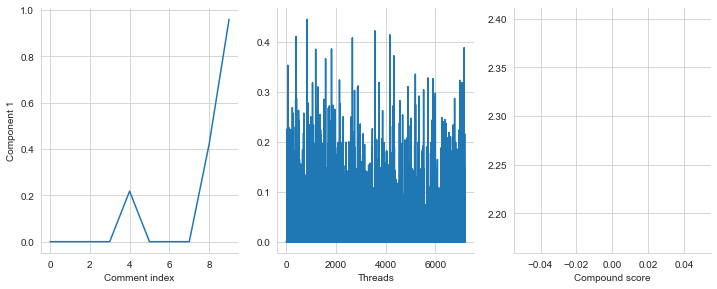

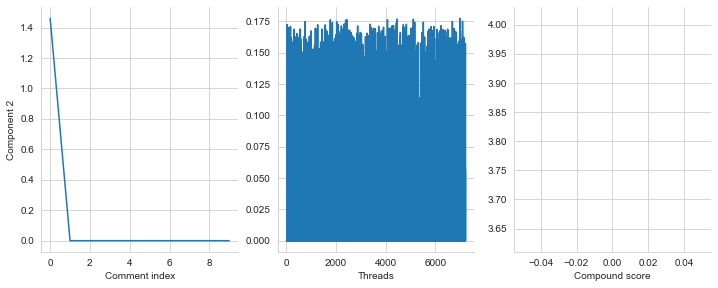

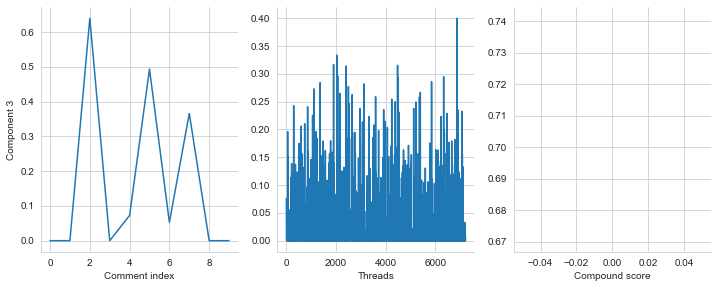

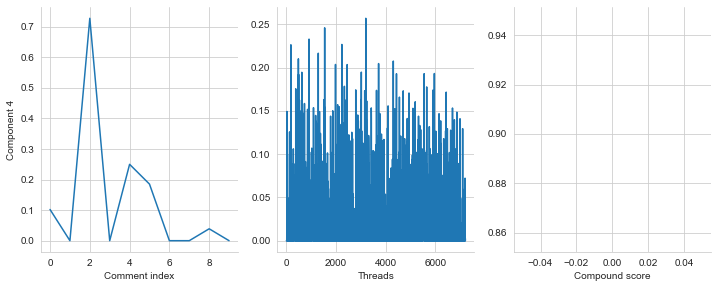

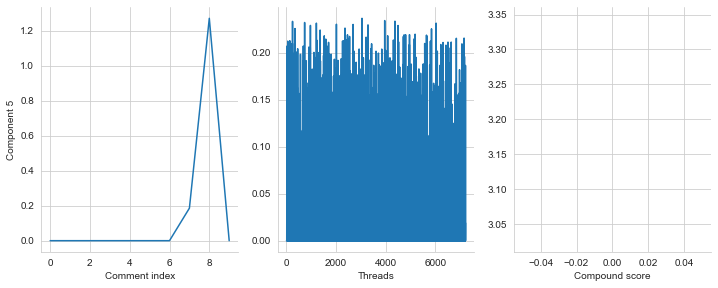

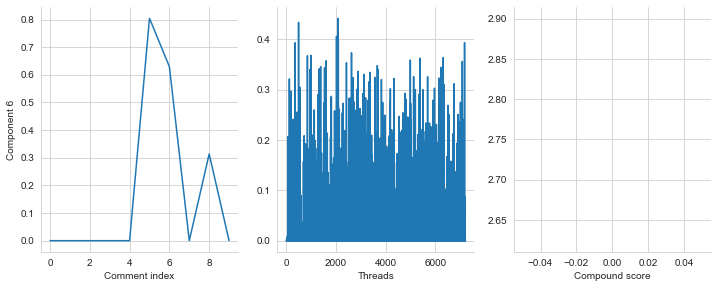

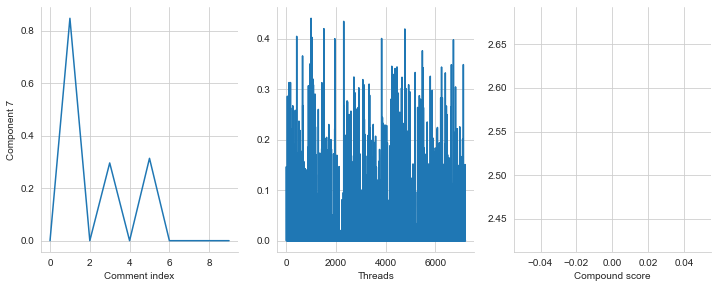

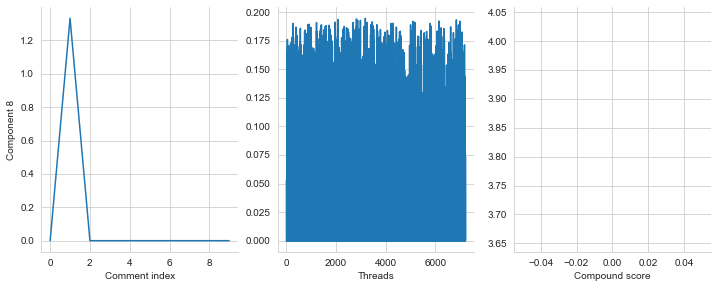

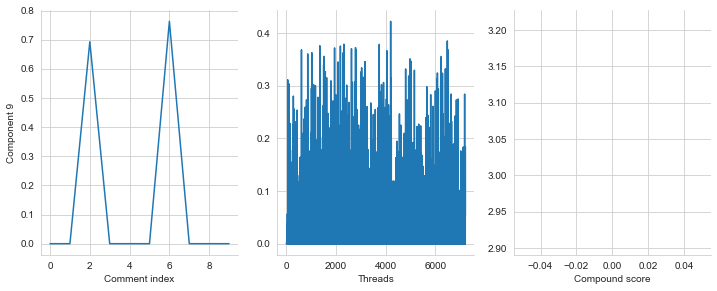

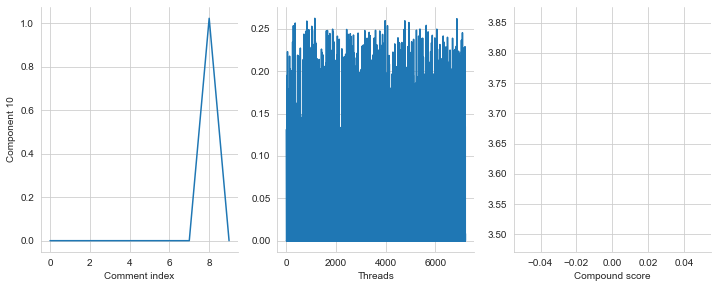

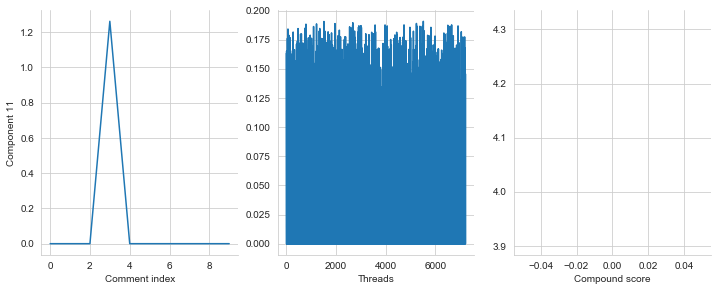

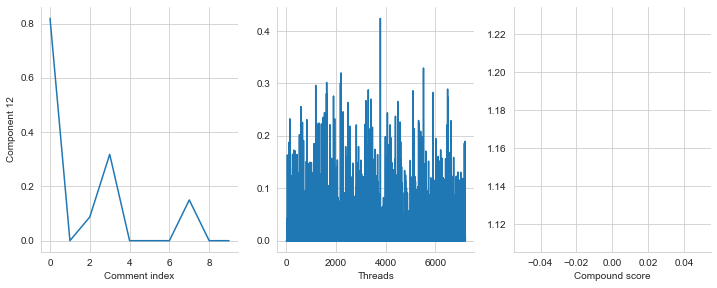

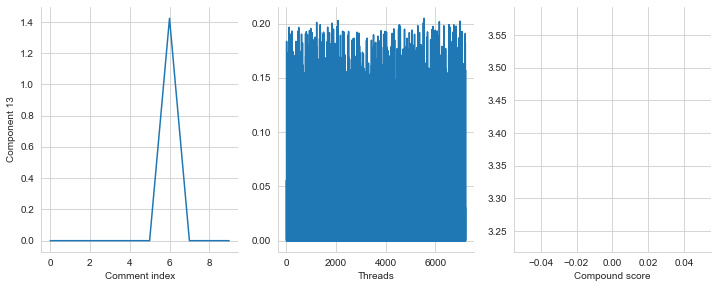

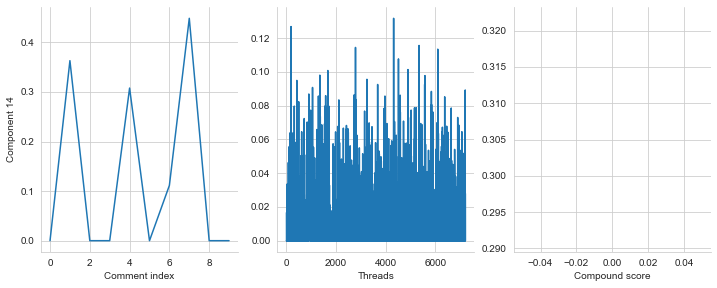

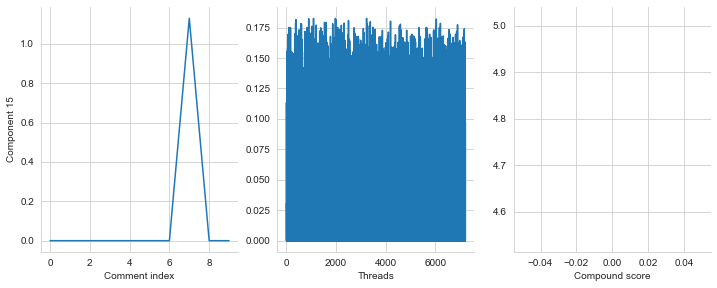

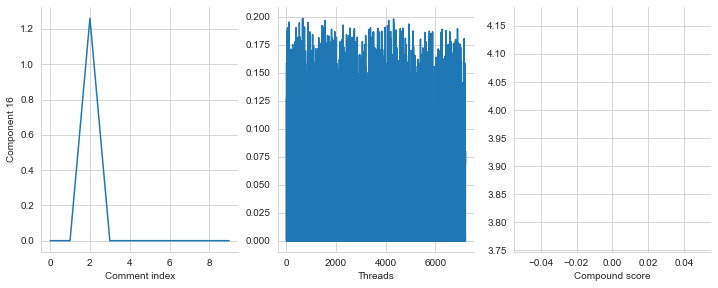

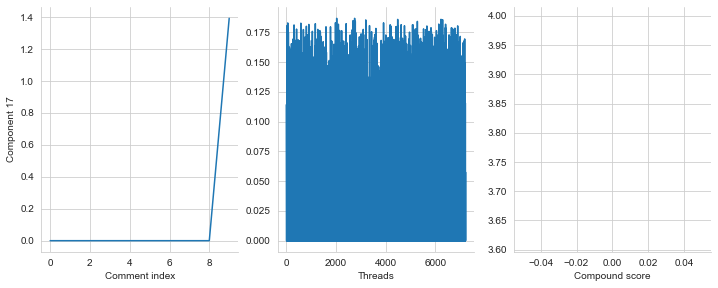

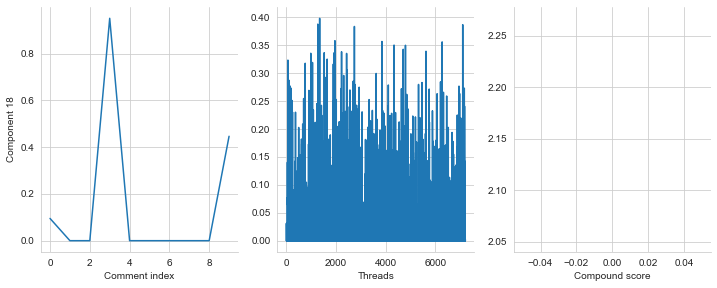

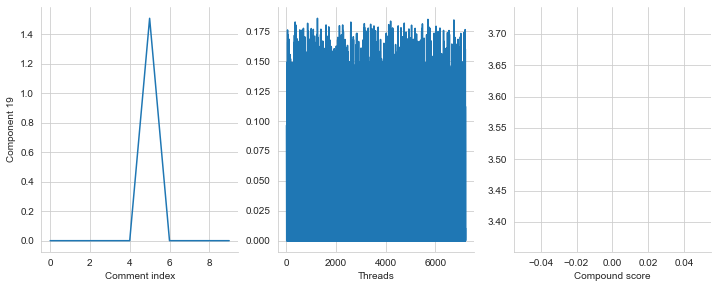

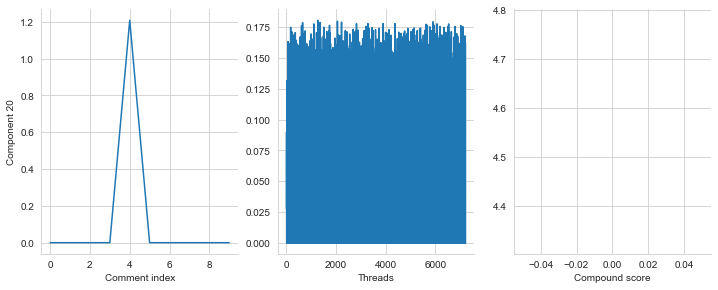

In [42]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Compound score'], 
             output_dir='.', 
             report_title='TCA-sentiment', 
             liwc=True)

In [43]:
corpus.append_vector_matrix(td.factor2_matrix)

In [44]:
corpus.vectors

{'bow_vector', 'threads'}

In [45]:
vclf_TCA = VectorClassifier(vector_name='threads', labeller=lambda convo: convo.meta['has_dispute'],
                           obj_type='conversation')

Initialized default classification model (standard scaled logistic regression).


In [46]:
res = vclf_TCA.evaluate_with_cv(corpus)

Running a cross-validated evaluation...Done.


In [47]:
np.mean(res)

0.5189832278474938

#### TCA but with labels

In [59]:
for convo in corpus.iter_conversations():
    for idx, utt in enumerate(list(convo.iter_utterances())[:10], start=1):
        convo.meta[f'sentiment-label-{idx}'] = {'positive': int(utt.meta['positive']),
                                                'negative': int(utt.meta['negative']),
                                                'neutral': int(utt.meta['neutral'])}

In [60]:
td_labels = TensorDecomposer(obj_type='conversation', 
                             feature_set=[f'sentiment-label-{idx}' for idx in range(1, 10+1)],
                             tensor_func='tensortools-ncp-bcd', rank=20)

In [61]:
td_labels.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.7838316787907476, improvement inf.
NCP_BCD: iteration 2, objective 0.7532092711393489, improvement 0.030622407651398675.
NCP_BCD: iteration 3, objective 0.7225133732659358, improvement 0.03069589787341309.
NCP_BCD: iteration 4, objective 0.6938054151391123, improvement 0.028707958126823474.
NCP_BCD: iteration 5, objective 0.6657418106678609, improvement 0.028063604471251447.
NCP_BCD: iteration 6, objective 0.6370994931355379, improvement 0.028642317532322936.
NCP_BCD: iteration 7, objective 0.609810544304312, improvement 0.0272889488312259.
NCP_BCD: iteration 8, objective 0.5845000483991168, improvement 0.025310495905195185.
NCP_BCD: iteration 9, objective 0.5642279809087508, improvement 0.02027206749036603.
NCP_BCD: iteration 10, objective 0.5483151622773289, improvement 0.01591281863142191.
NCP_BCD: iteration 11, objective 0.5352000390704214, improvement 0.013115123206907553.
NCP_BCD: iteration 12, obj

Directory already exists. Exiting summarize()


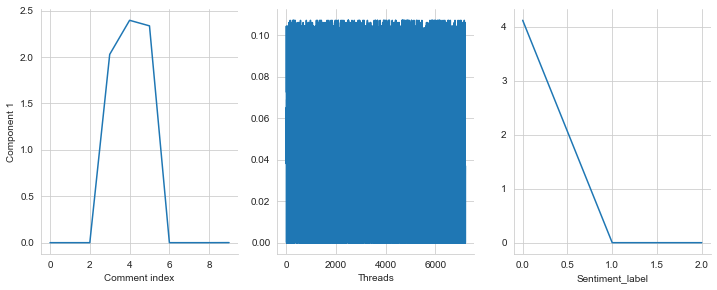

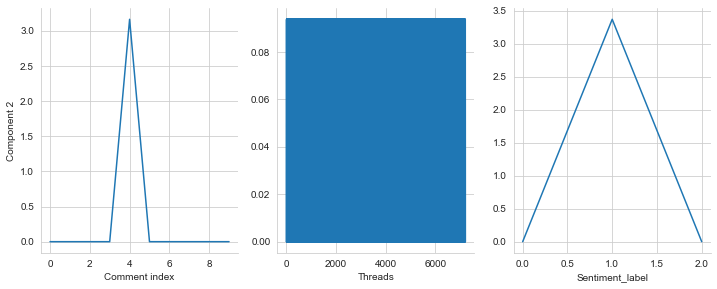

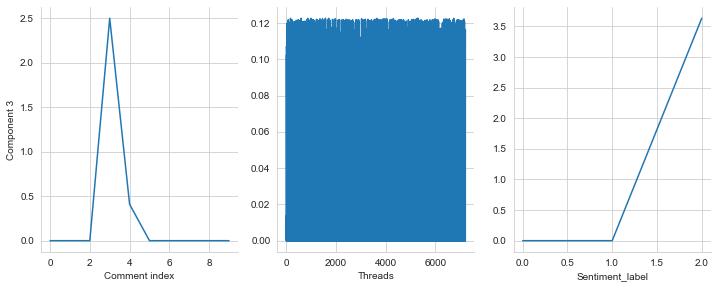

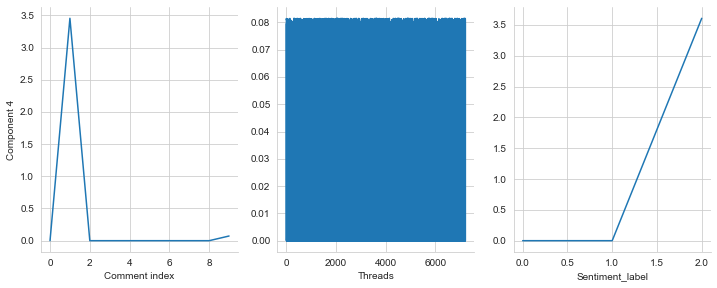

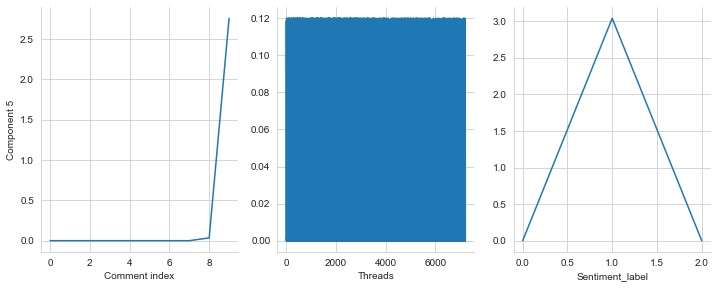

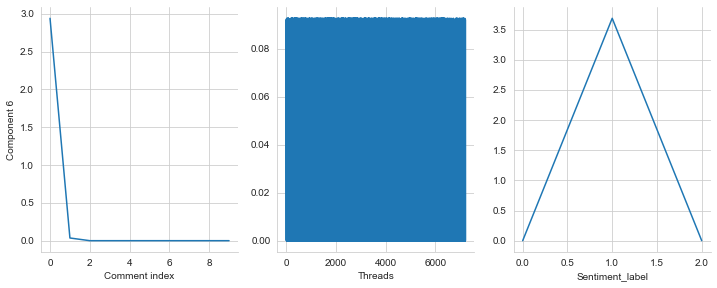

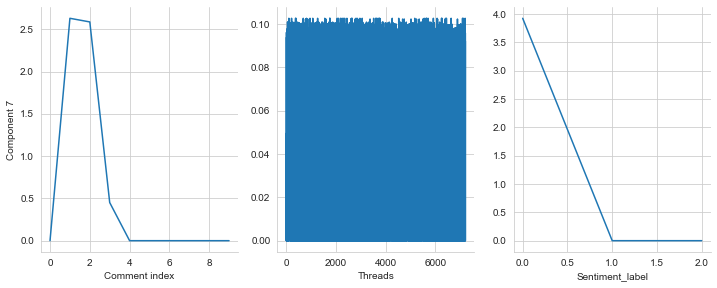

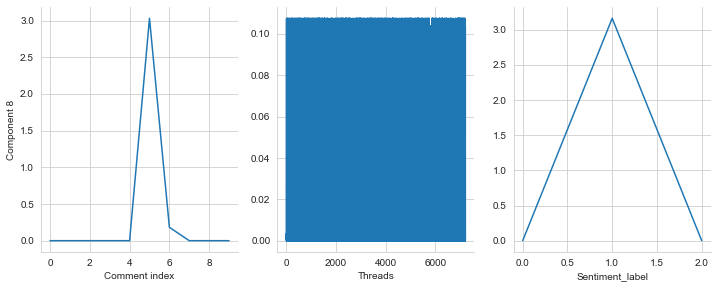

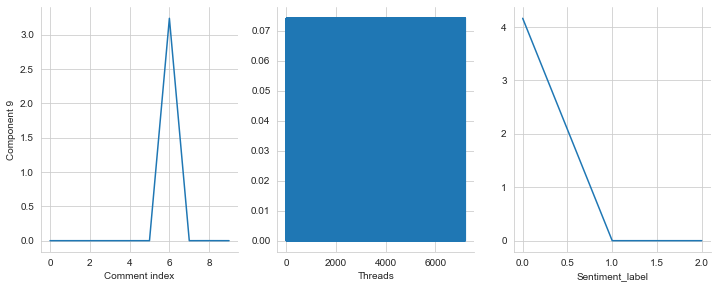

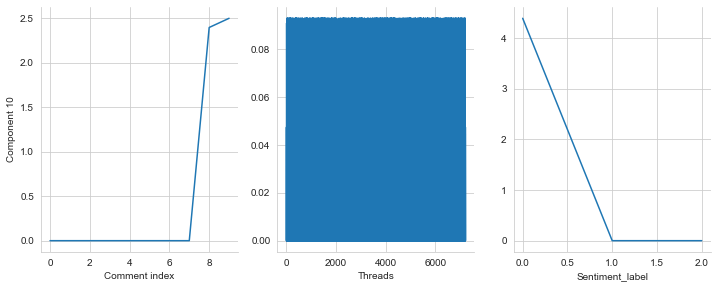

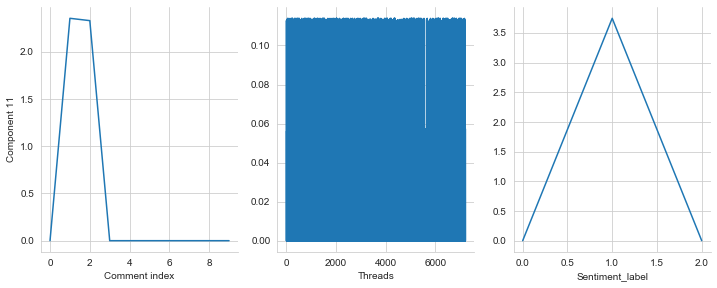

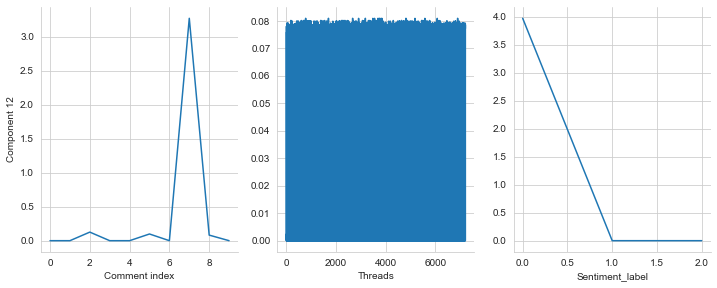

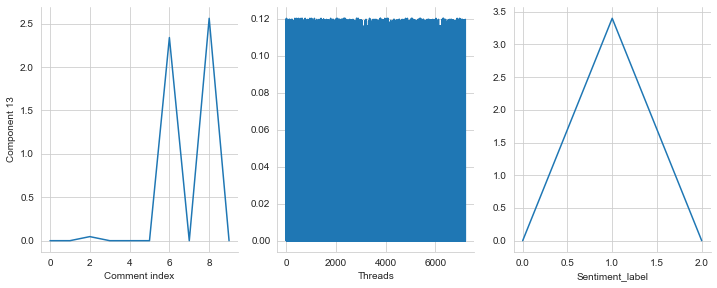

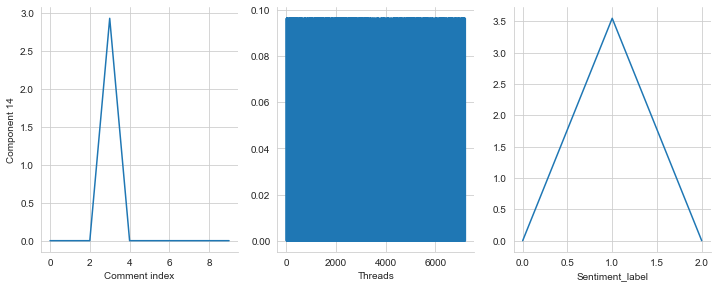

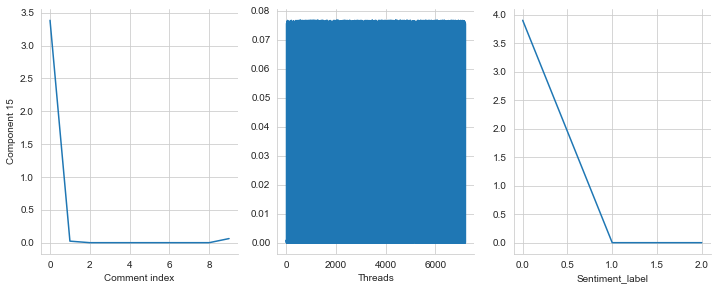

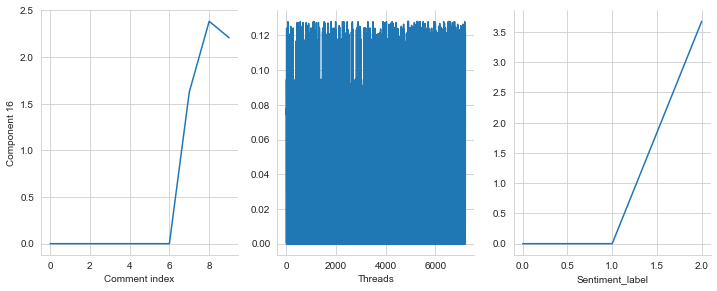

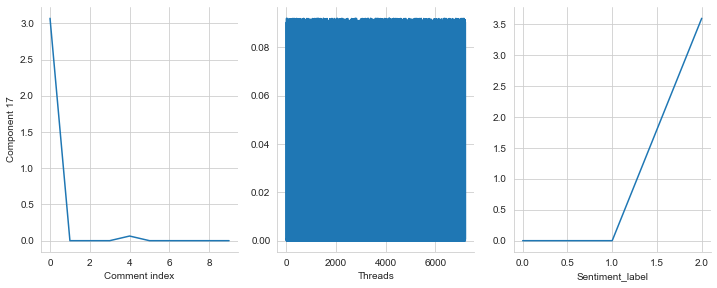

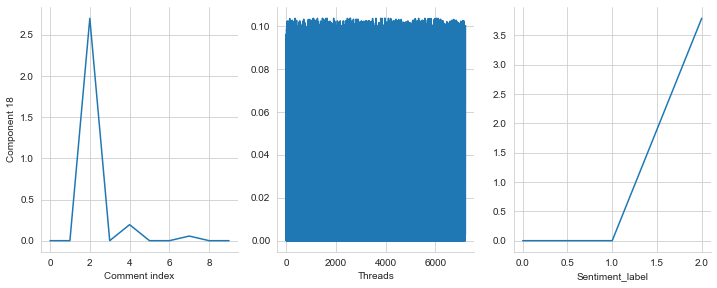

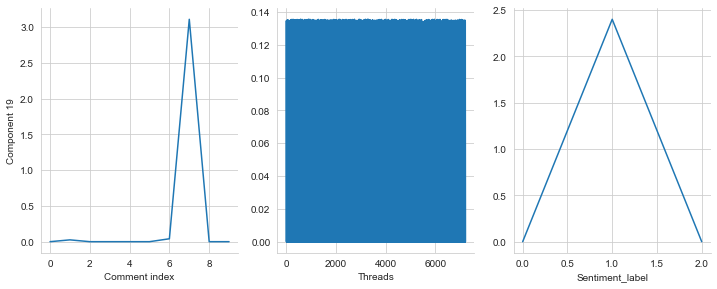

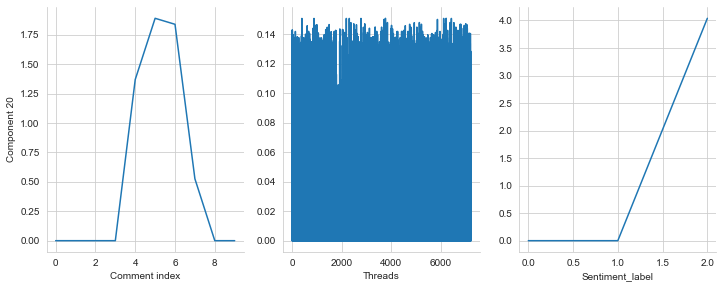

In [63]:
# Positive, negative, neutral
td_labels.summarize(corpus, axis_names=['Comment index', 'Threads', 'Sentiment_label'], 
             output_dir='.', 
             report_title='TCA-sentiment', 
             liwc=True)

In [65]:
td_labels.factor2_matrix.name = 'tca-labels'

In [66]:
corpus.append_vector_matrix(td_labels.factor2_matrix)

In [67]:
vclf_labels = VectorClassifier(obj_type='conversation', vector_name='tca-labels', labeller=lambda c: c.meta['has_dispute'])

Initialized default classification model (standard scaled logistic regression).


In [68]:
res = vclf_labels.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Running a cross-validated evaluation...Done.
[0.5900277  0.56648199 0.55955679 0.57380457 0.58489258]
0.5749527281383238


#### Another baseline: raw scores

In [53]:
for convo in corpus.iter_conversations():
    convo.meta['compound_scores'] = dict()
    for idx in range(1, 10+1):
        convo.meta['compound_scores'][idx] = convo.meta[f'compound-{idx}'][1]

In [55]:
sentiment_raw_clf = Classifier(obj_type='conversation', pred_feats=['compound_scores'], 
                               labeller=lambda convo: convo.meta['has_dispute'])

Initialized default classification model (standard scaled logistic regression).


In [56]:
res = sentiment_raw_clf.evaluate_with_cv(corpus)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [57]:
print(np.mean(res))
print(res)

0.5148230160695534
[0.50415512 0.54293629 0.50484765 0.51212751 0.51004851]


In [18]:
corpus.random_conversation().meta

{'discussion_name': 'Nasal vowels',
 'page_ID': '7131',
 'page_name': 'Discussion:Latin spelling and pronunciation',
 'has_dispute': False,
 'discussion_feats': {'num_turns': 12,
  'num_participants': 4,
  'avg_num_words_per_turn': 40.75},
 'global_sentiment': {'global_num_positive': 3,
  'global_num_neutral': 5,
  'global_num_negative': 4,
  'global_prob_positive': 0.25,
  'global_pos_neutral': 0.4166666666666667,
  'global_pos_negative': 0.3333333333333333,
  'global_prob_positive->positive': 0.0,
  'global_prob_positive->negative': 0.09090909090909091,
  'global_prob_positive->neutral': 0.09090909090909091,
  'global_prob_negative->positive': 0.18181818181818182,
  'global_prob_negative->negative': 0.18181818181818182,
  'global_prob_negative->neutral': 0.0,
  'global_prob_neutral->positive': 0.09090909090909091,
  'global_prob_neutral->negative': 0.09090909090909091,
  'global_prob_neutral->neutral': 0.2727272727272727},
 '1st_third_sentiment': {'1/3_num_positive': 1,
  '1/3_num_ne

### TCA: attempting to use all the data points by 'normalizing' to 40 data points

In [144]:
for convo in corpus.iter_conversations():
    scores = np.array([utt.meta['compound'] for utt in convo.iter_utterances()])
    resampled = resampy.resample(scores, sr_orig=len(scores), sr_new=40).tolist()
    if len(resampled) != 40:
        resampled = np.array(resampled)
        resampled = resampy.resample(resampled, sr_orig=resampled.shape[0], sr_new=40)
    for i in range(1, 40+1):
        convo.meta[f'resampled-{i}'] = {1: resampled[i-1]}

In [147]:
td_interpolated_raw = TensorDecomposer(obj_type='conversation', 
                                       feature_set=[f'resampled-{idx}' for idx in range(1, 40+1)],
                                       tensor_func='tensortools-ncp-bcd', rank=30
                                      )

In [148]:
td_interpolated_raw.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.9041836324424868, improvement inf.
NCP_BCD: iteration 2, objective 0.8868711616638214, improvement 0.01731247077866538.
NCP_BCD: iteration 3, objective 0.8676333349167751, improvement 0.019237826747046327.
NCP_BCD: iteration 4, objective 0.848254865584583, improvement 0.019378469332192116.
NCP_BCD: iteration 5, objective 0.829771095307229, improvement 0.018483770277353928.
NCP_BCD: iteration 6, objective 0.8132660625027438, improvement 0.01650503280448523.
NCP_BCD: iteration 7, objective 0.7992321441921907, improvement 0.014033918310553117.
NCP_BCD: iteration 8, objective 0.7875892966437791, improvement 0.011642847548411606.
NCP_BCD: iteration 9, objective 0.777106208495273, improvement 0.01048308814850607.
NCP_BCD: iteration 10, objective 0.7677027498870312, improvement 0.009403458608241766.
NCP_BCD: iteration 11, objective 0.7599075159023215, improvement 0.007795233984709715.
NCP_BCD: iteration 12, obj

NCP_BCD: iteration 96, objective 0.6394454878217263, improvement 9.474063701719881e-05.
NCP_BCD: iteration 97, objective 0.6393393444635838, improvement 0.00010614335814251863.
NCP_BCD: iteration 98, objective 0.6392225708203717, improvement 0.00011677364321205363.
NCP_BCD: iteration 99, objective 0.6391226681942284, improvement 9.990262614334444e-05.
NCP_BCD: iteration 100, objective 0.639017431008191, improvement 0.00010523718603738796.
NCP_BCD: iteration 101, objective 0.6389066543832395, improvement 0.00011077662495151408.
NCP_BCD: iteration 102, objective 0.638790007974571, improvement 0.00011664640866848597.
NCP_BCD: iteration 103, objective 0.63866678924474, improvement 0.00012321872983100945.
NCP_BCD: iteration 104, objective 0.6385359019970992, improvement 0.0001308872476407652.
NCP_BCD: iteration 105, objective 0.6383955531029264, improvement 0.00014034889417280372.
NCP_BCD: iteration 106, objective 0.6382433784043505, improvement 0.00015217469857586874.
NCP_BCD: iteration 10

/Users/calebchiam/Documents/GitHub/Cornell-Conversational-Analysis-Toolkit/convokit/tensor_decomposer/tensorDecomposer.py:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, d, figsize=(12, 4.5))


Directory already exists. Exiting summarize()


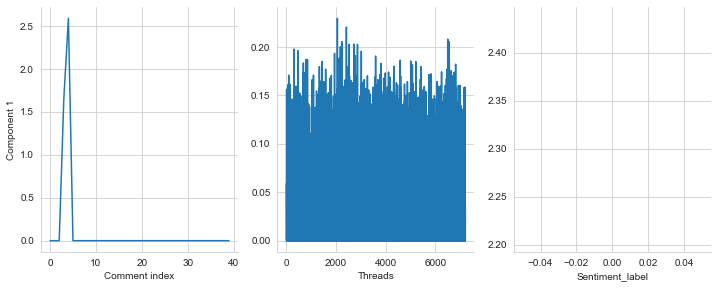

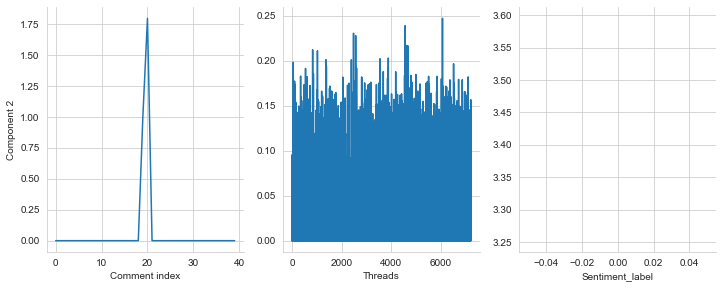

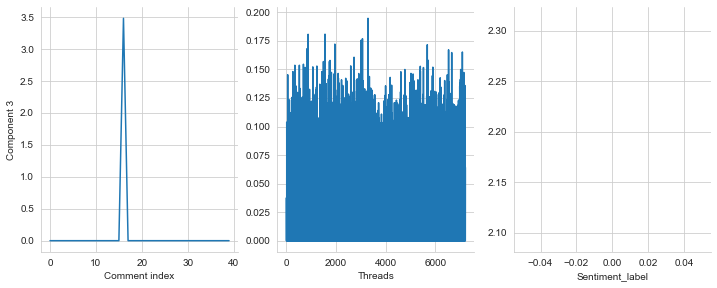

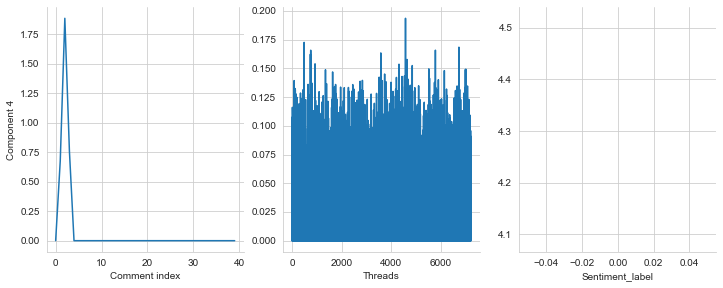

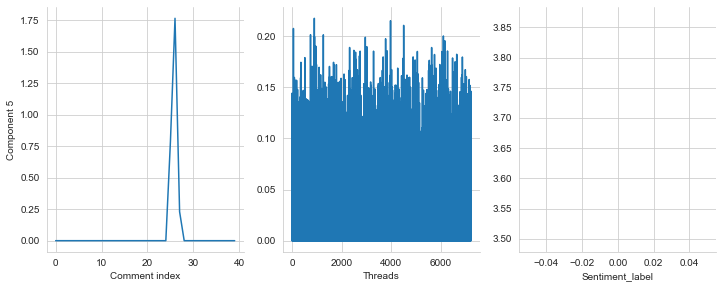

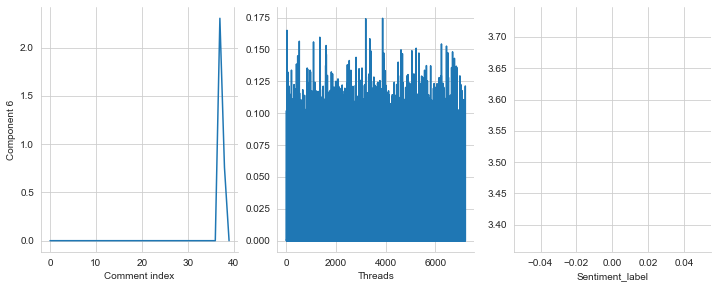

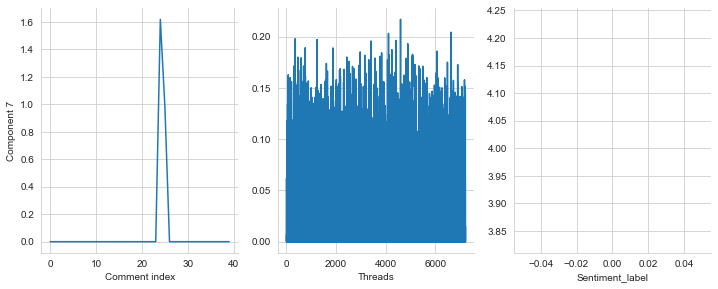

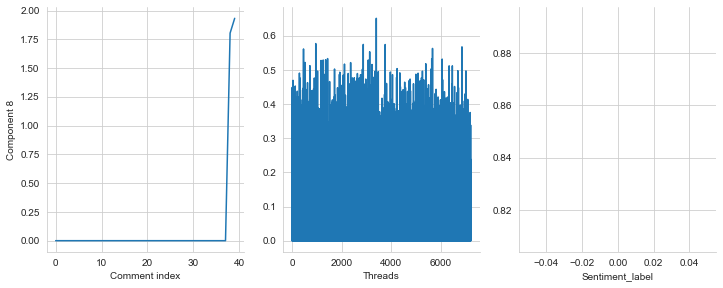

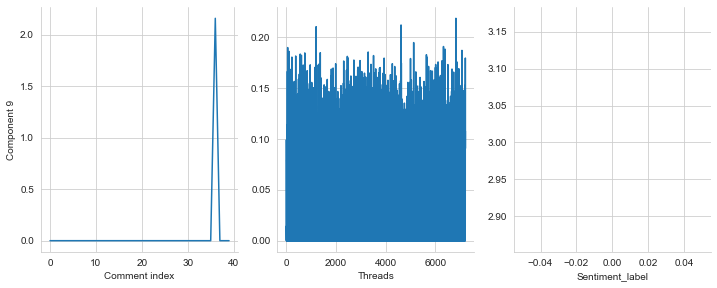

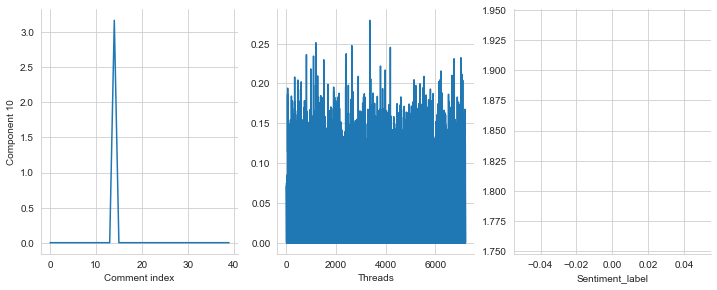

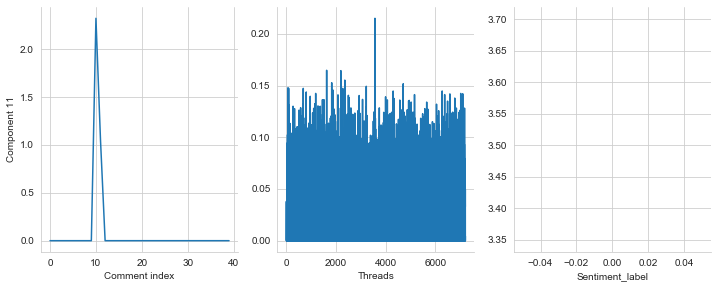

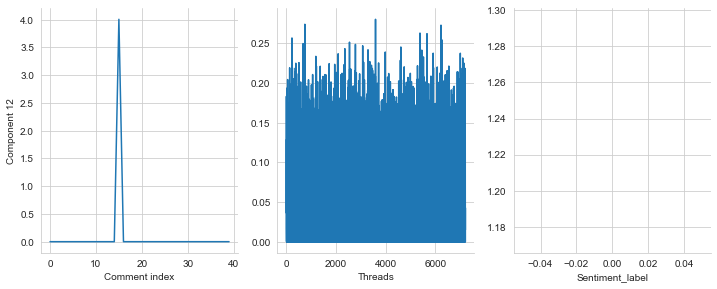

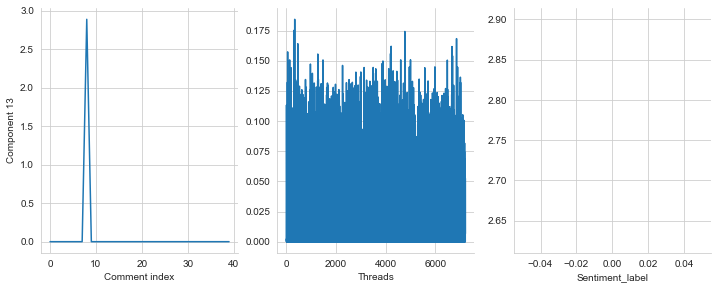

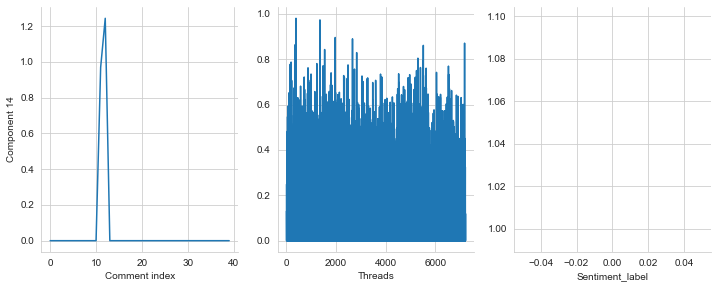

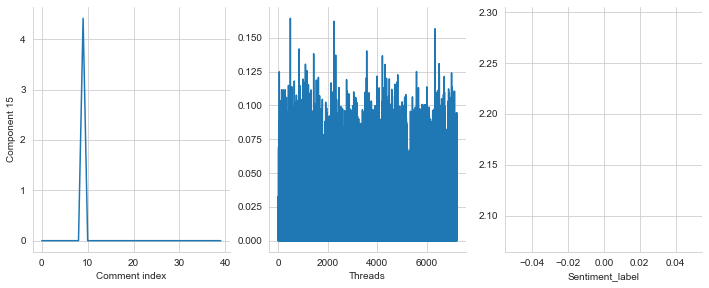

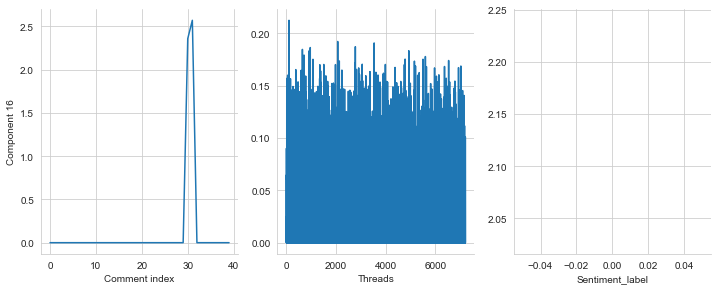

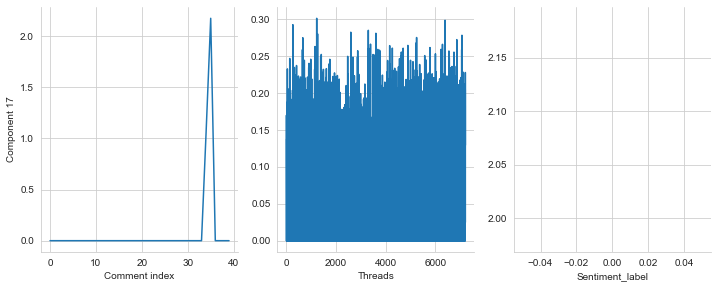

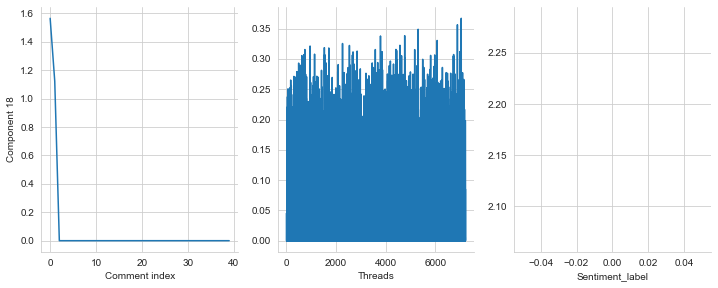

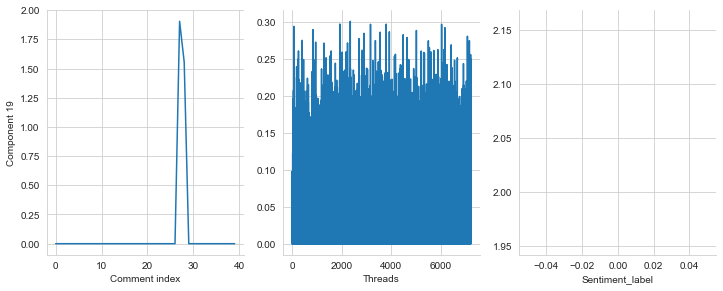

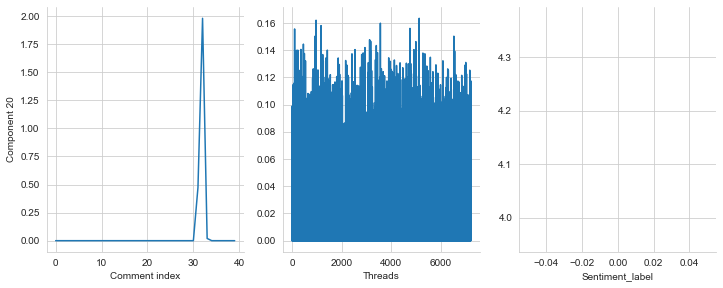

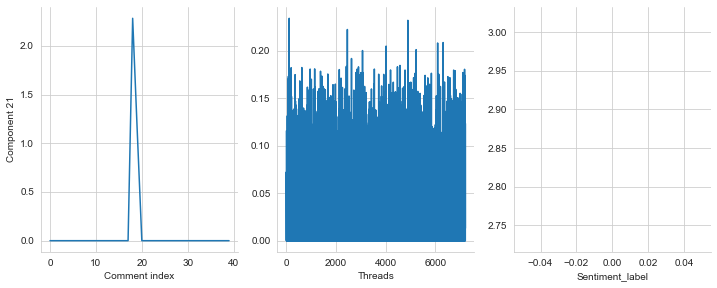

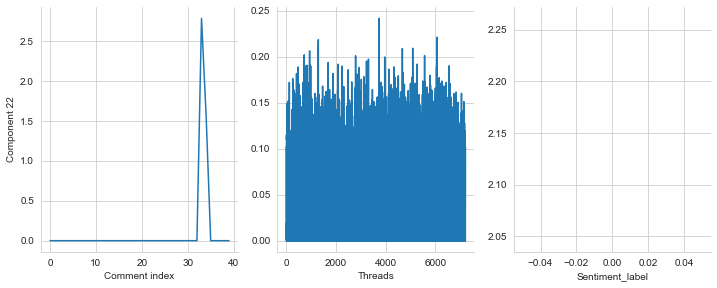

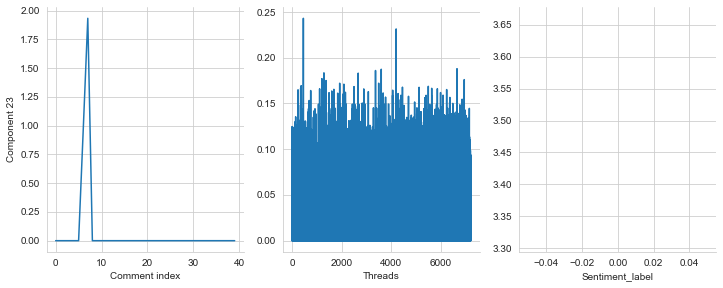

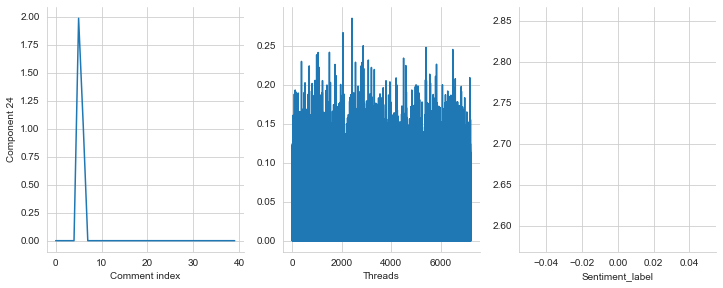

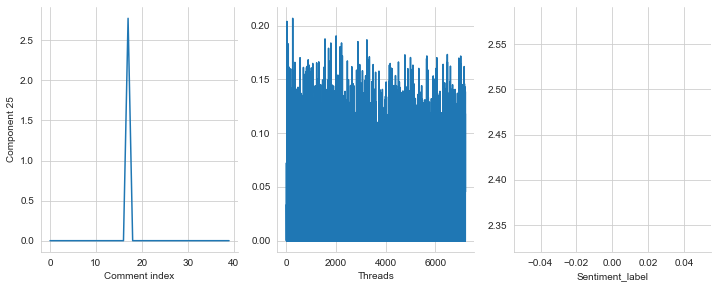

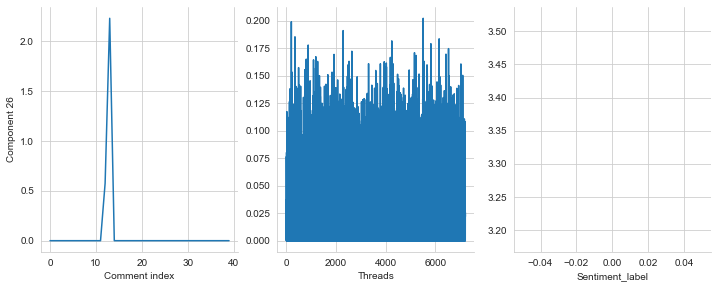

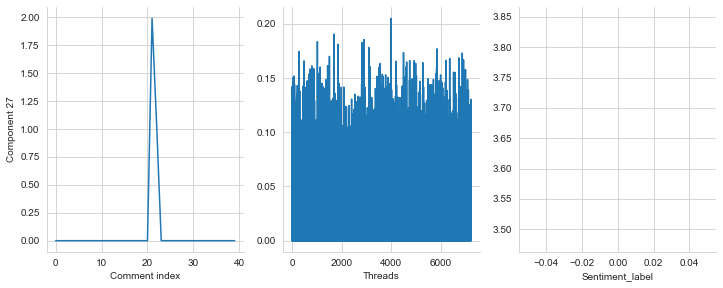

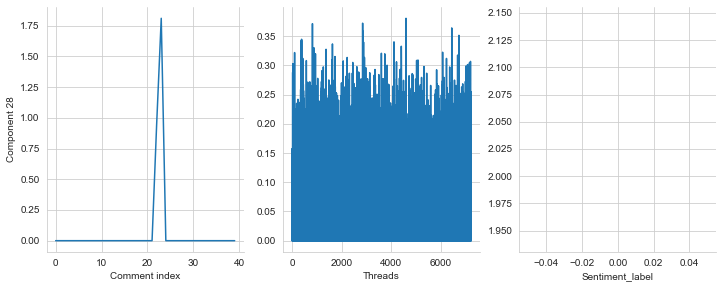

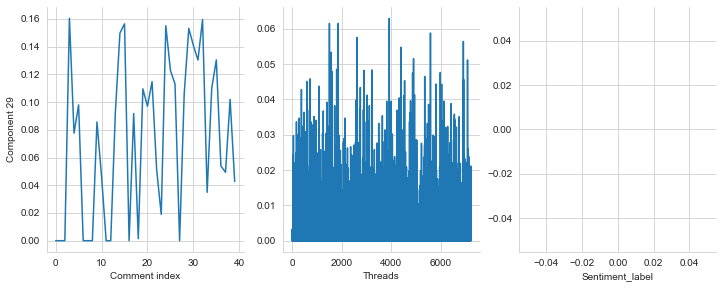

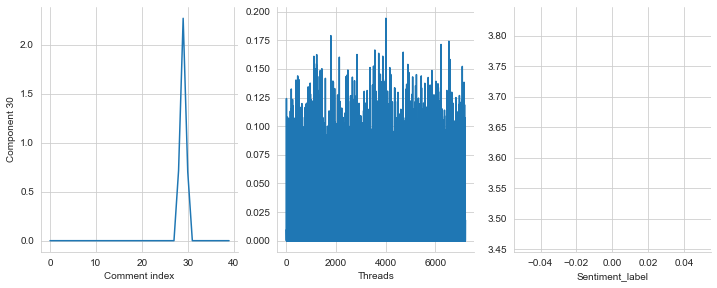

In [149]:
# Positive, negative, neutral
td_interpolated_raw.summarize(corpus, axis_names=['Comment index', 'Threads', 'Sentiment_label'], 
             output_dir='.', 
             report_title='TCA-sentiment', 
             liwc=True)

In [151]:
td_interpolated_raw.factor2_matrix.name = 'interpolated_raw'
corpus.append_vector_matrix(td_interpolated_raw.factor2_matrix)

In [152]:
vclf_interpolated_raw = VectorClassifier(obj_type='conversation', vector_name='interpolated_raw',
                                        labeller=lambda c: c.meta['has_dispute'])

Initialized default classification model (standard scaled logistic regression).


In [153]:
res = vclf_interpolated_raw.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Running a cross-validated evaluation...Done.
[0.53739612 0.53947368 0.55193906 0.53291753 0.52390852]
0.537126984218397


In [155]:
for convo in corpus.iter_conversations():
    scores = np.array([utt.meta['compound'] for utt in convo.iter_utterances()])
    resampled = resampy.resample(scores, sr_orig=len(scores), sr_new=40).tolist()
    if len(resampled) != 40:
        resampled = np.array(resampled)
        resampled = resampy.resample(resampled, sr_orig=resampled.shape[0], sr_new=40)
    for i in range(1, 40+1):
        pos, neu, neg = output_sentiment_labels(resampled[i-1])
        convo.meta[f'resampled-{i}'] = {'positive': int(pos), 'neutral': int(neu), 'negative': int(neg)}

In [156]:
td_interpolated_labels = TensorDecomposer(obj_type='conversation', 
                                       feature_set=[f'resampled-{idx}' for idx in range(1, 40+1)],
                                       tensor_func='tensortools-ncp-bcd', rank=30
                                      )

In [159]:
td_interpolated_labels.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.7553276210529684, improvement inf.
NCP_BCD: iteration 2, objective 0.7420448946608783, improvement 0.01328272639209005.
NCP_BCD: iteration 3, objective 0.7308543790152627, improvement 0.011190515645615573.
NCP_BCD: iteration 4, objective 0.7217984773526592, improvement 0.009055901662603505.
NCP_BCD: iteration 5, objective 0.714707583411005, improvement 0.007090893941654186.
NCP_BCD: iteration 6, objective 0.7076137503352659, improvement 0.0070938330757391865.
NCP_BCD: iteration 7, objective 0.6994891612493733, improvement 0.00812458908589253.
NCP_BCD: iteration 8, objective 0.6906518781141617, improvement 0.008837283135211593.
NCP_BCD: iteration 9, objective 0.6815028614008255, improvement 0.009149016713336233.
NCP_BCD: iteration 10, objective 0.6723815917822289, improvement 0.009121269618596606.
NCP_BCD: iteration 11, objective 0.6635285636671776, improvement 0.008853028115051287.
NCP_BCD: iteration 12,

NCP_BCD: iteration 96, objective 0.5372342860205204, improvement 2.759484891234898e-05.
NCP_BCD: iteration 97, objective 0.5372047268039233, improvement 2.9559216597085936e-05.
NCP_BCD: iteration 98, objective 0.5371724194102019, improvement 3.2307393721398014e-05.
NCP_BCD: iteration 99, objective 0.5371364002481057, improvement 3.601916209616807e-05.
NCP_BCD: iteration 100, objective 0.5370960267910135, improvement 4.0373457092179876e-05.
NCP_BCD: iteration 101, objective 0.5370512224582245, improvement 4.480433278908347e-05.
NCP_BCD: iteration 102, objective 0.5370013456959372, improvement 4.98767622872931e-05.
NCP_BCD: iteration 103, objective 0.5369455209012907, improvement 5.5824794646497367e-05.
NCP_BCD: iteration 104, objective 0.5368826264590145, improvement 6.289444227614016e-05.
NCP_BCD: iteration 105, objective 0.536811328683356, improvement 7.129777565850759e-05.
NCP_BCD: iteration 106, objective 0.5367301815376092, improvement 8.114714574680715e-05.
NCP_BCD: iteration 107,

/Users/calebchiam/Documents/GitHub/Cornell-Conversational-Analysis-Toolkit/convokit/tensor_decomposer/tensorDecomposer.py:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, d, figsize=(12, 4.5))


Directory already exists. Exiting summarize()


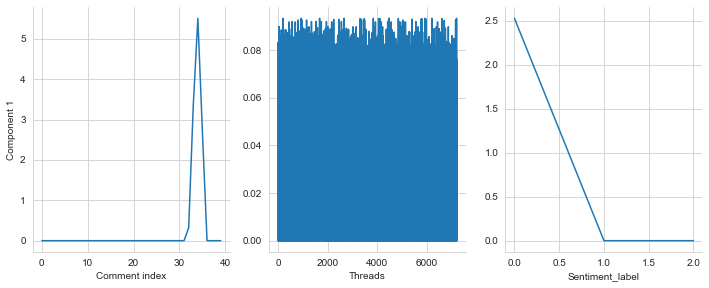

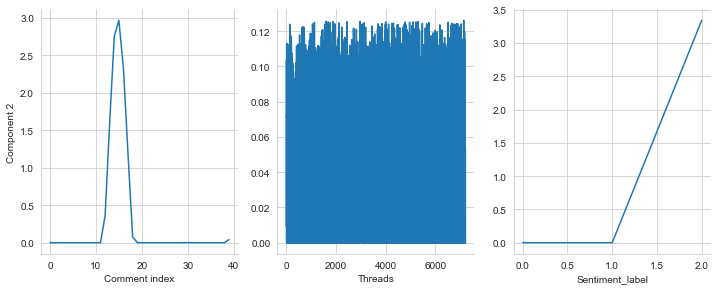

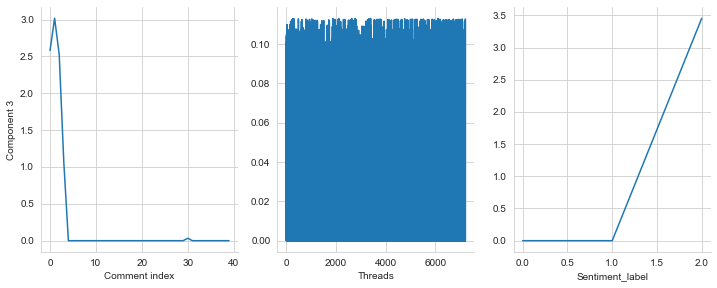

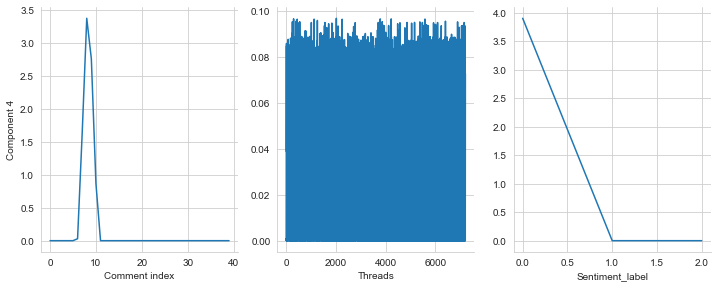

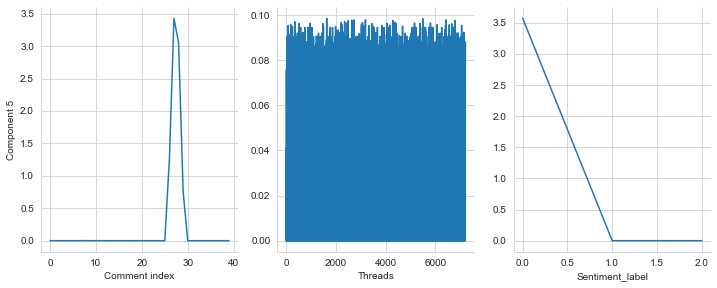

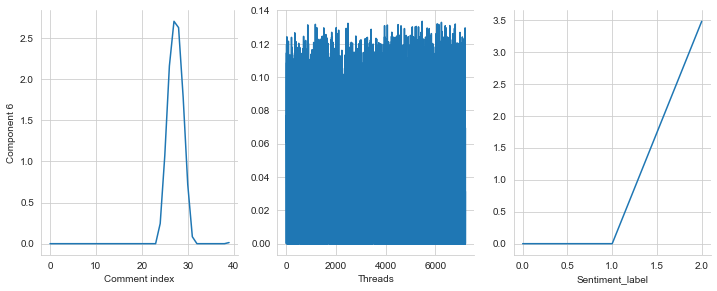

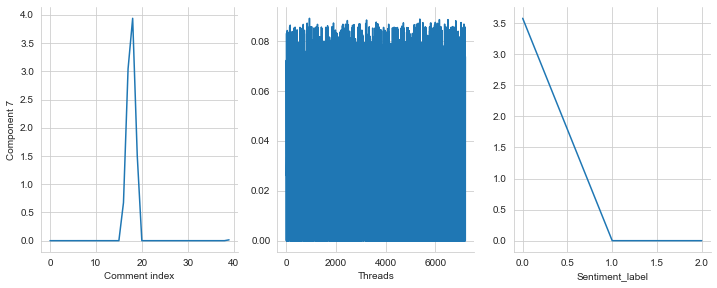

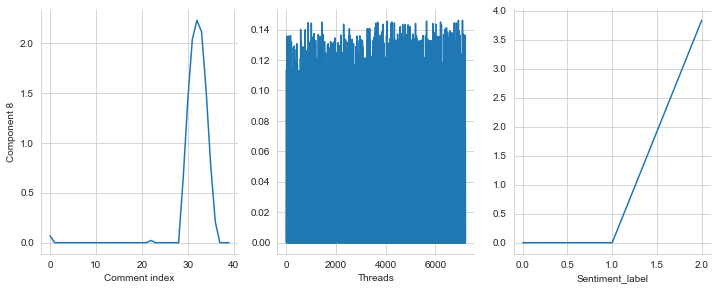

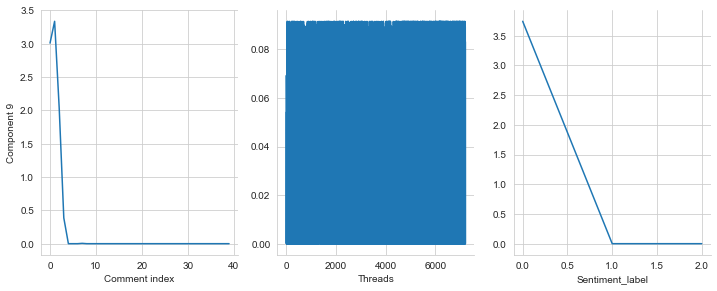

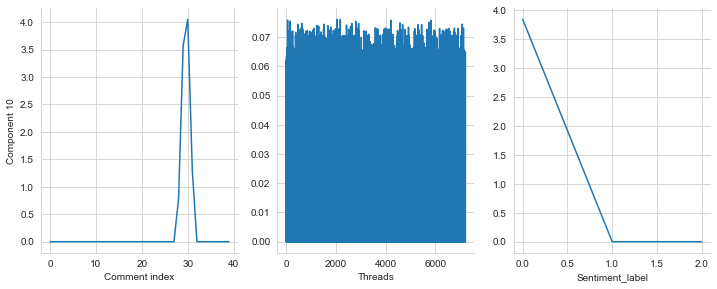

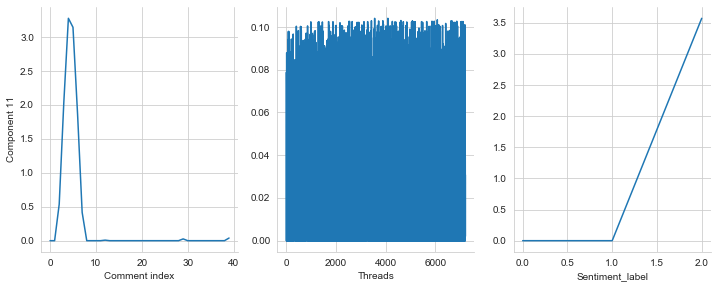

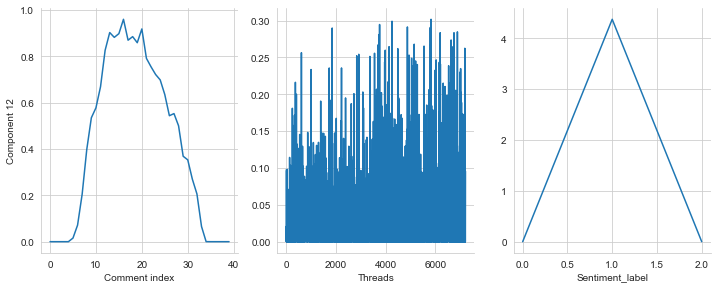

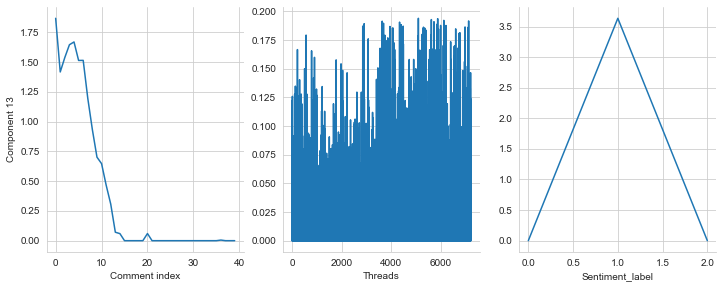

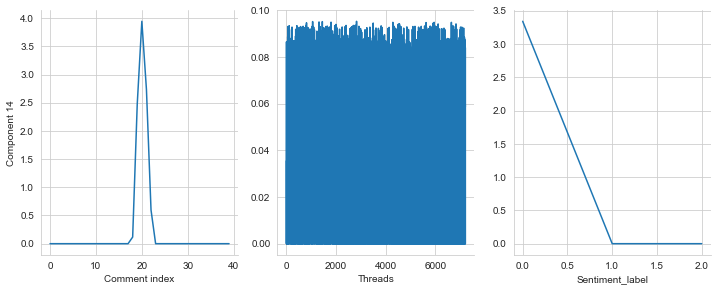

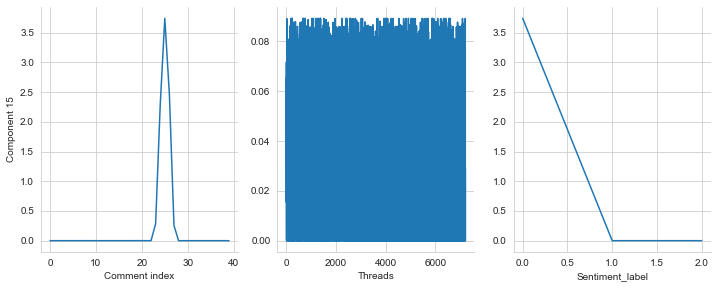

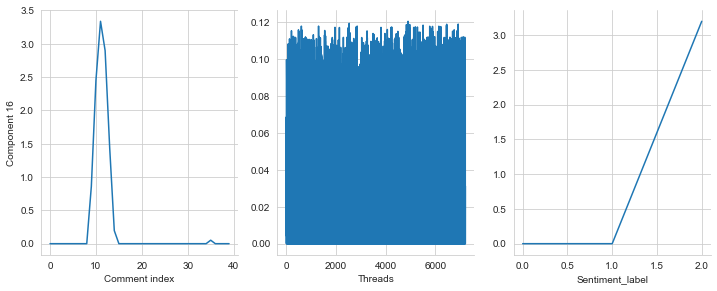

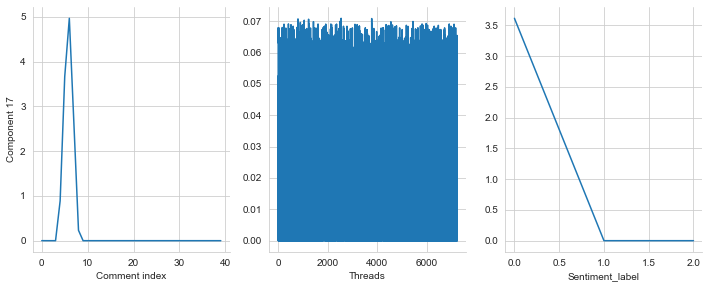

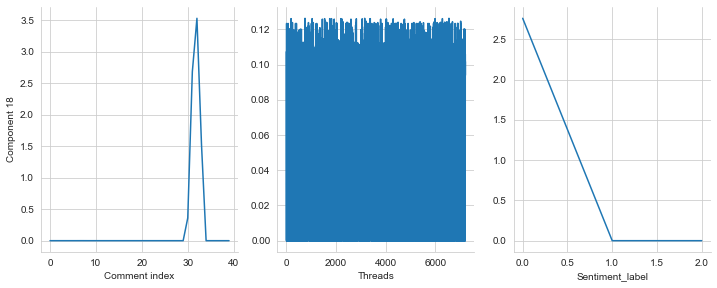

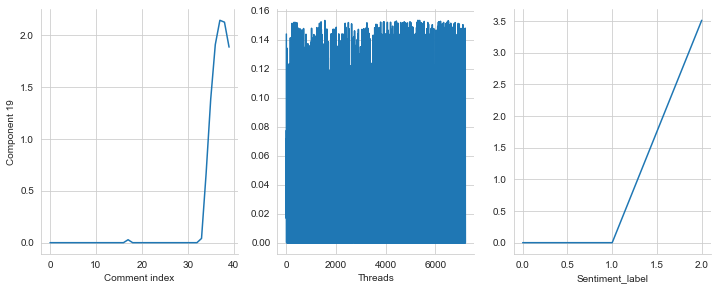

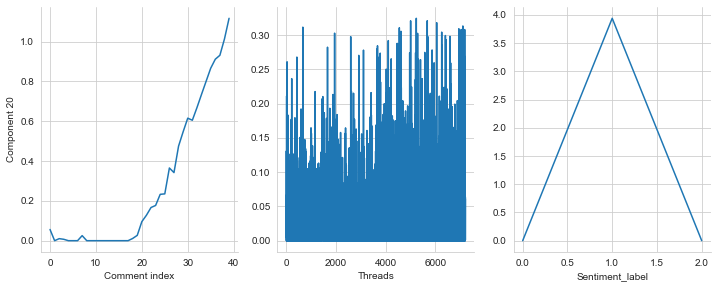

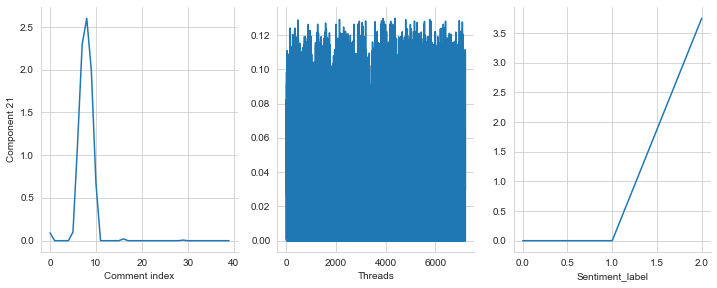

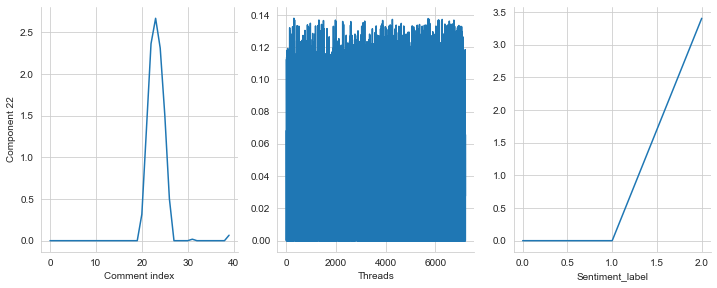

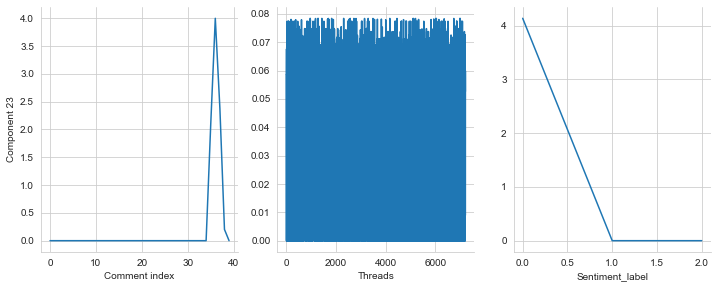

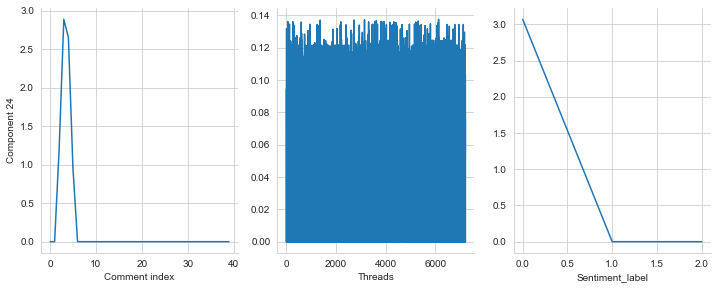

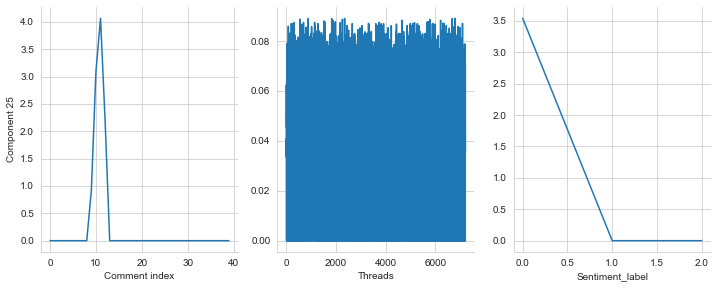

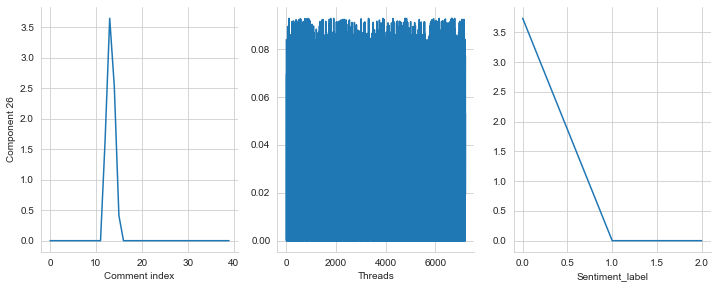

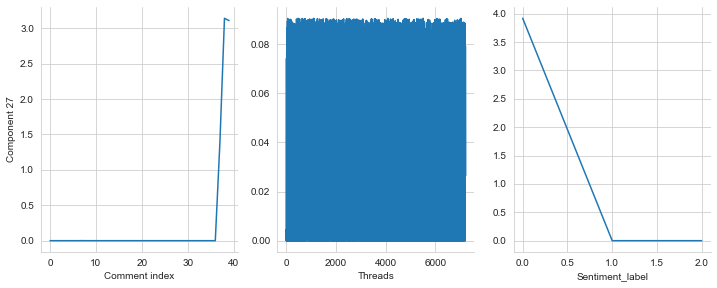

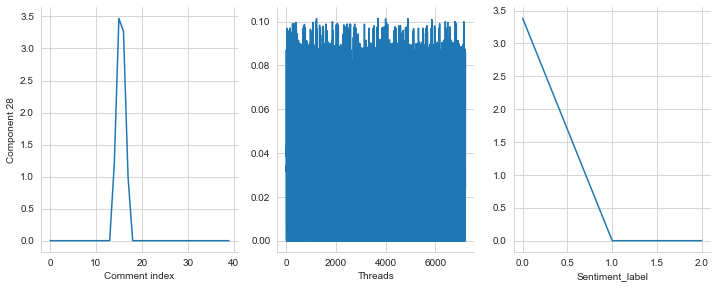

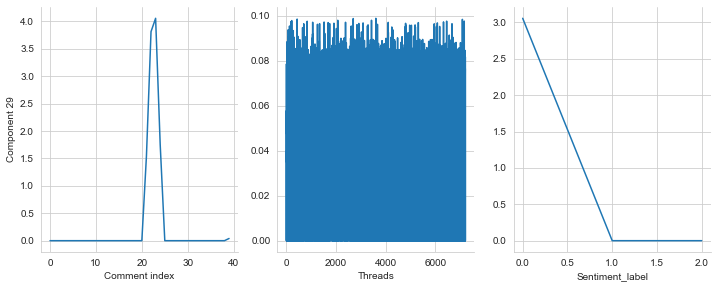

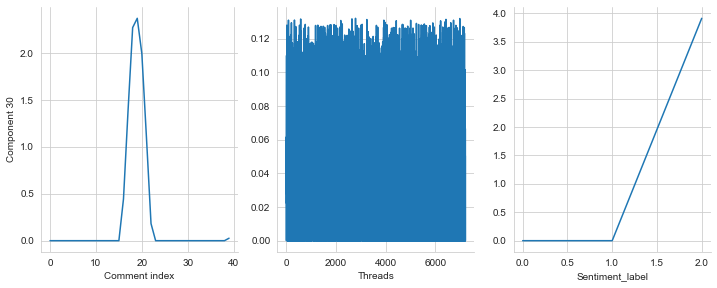

In [160]:
# positive neutral negative`
td_interpolated_labels.summarize(corpus, axis_names=['Comment index', 'Threads', 'Sentiment_label'], 
             output_dir='.', 
             report_title='TCA-sentiment', 
             liwc=True)

In [161]:
td_interpolated_labels.factor2_matrix.name = 'interpolated_labels'
corpus.append_vector_matrix(td_interpolated_labels.factor2_matrix)

In [162]:
vclf_interpolated_labels = VectorClassifier(obj_type='conversation', vector_name='interpolated_labels',
                                        labeller=lambda c: c.meta['has_dispute'])

Initialized default classification model (standard scaled logistic regression).


In [163]:
res = vclf_interpolated_labels.evaluate_with_cv(corpus)
print(np.mean(res))
print(res)

Running a cross-validated evaluation...Done.
0.5932400757885523
[0.59764543 0.55955679 0.61565097 0.59043659 0.6029106 ]


#### Using raw interpolated data points

In [164]:
for convo in corpus.iter_conversations():
    scores = np.array([utt.meta['compound'] for utt in convo.iter_utterances()])
    resampled = resampy.resample(scores, sr_orig=len(scores), sr_new=40).tolist()
    if len(resampled) != 40:
        resampled = np.array(resampled)
        resampled = resampy.resample(resampled, sr_orig=resampled.shape[0], sr_new=40).tolist()
    convo.meta['resampled_data'] = {k: v for k, v in enumerate(resampled)}

In [166]:
clf_resampled = Classifier(obj_type='conversation', pred_feats=['resampled_data'], 
                          labeller=lambda c: c.meta['has_dispute'])

Initialized default classification model (standard scaled logistic regression).


In [167]:
res = clf_resampled.evaluate_with_cv(corpus)
print(np.mean(res))
print(res)

Using corpus objects...
Running a cross-validated evaluation...
Done.
0.5177347707818621
[0.50484765 0.50900277 0.52977839 0.53014553 0.51489951]


### Sentiment + TCA-interpolated

In [180]:
global_senti = dict()
for convo in corpus.iter_conversations():
    global_senti[convo.id] = convo.meta['global_sentiment']

In [184]:
global_senti_df = pd.DataFrame(global_senti).T

In [185]:
from convokit import ConvoKitMatrix

In [189]:
global_senti_matrix = ConvoKitMatrix(name='global_sentiment', matrix=global_senti_df.values, 
                                     ids=global_senti_df.index, columns=list(global_senti_df.columns))

In [190]:
corpus.append_vector_matrix(global_senti_matrix)

In [191]:
vclf_senti = VectorClassifier(obj_type='conversation', vector_name='global_sentiment',
                              labeller=lambda c: c.meta['has_dispute']
                             )

Initialized default classification model (standard scaled logistic regression).


In [202]:
np.mean(vclf_senti.evaluate_with_cv(corpus))

Running a cross-validated evaluation...Done.


0.728595876933827

In [194]:
corpus.vectors

{'bow_vector',
 'global_sentiment',
 'interpolated_labels',
 'interpolated_raw',
 'tca-labels',
 'threads'}

In [200]:
corpus.append_vector_matrix(ConvoKitMatrix.hstack(name='global_senti+interpolated_labels', 
                      matrices=[corpus.get_vector_matrix('global_sentiment'), 
                                corpus.get_vector_matrix('interpolated_labels')]))

In [201]:
vclf_combined = VectorClassifier(obj_type='conversation', vector_name='global_senti+interpolated_labels',
                              labeller=lambda c: c.meta['has_dispute']
                             )

Initialized default classification model (standard scaled logistic regression).


In [210]:
corpus.get_vector_matrix('global_senti+interpolated_labels').matrix = corpus.get_vector_matrix('global_senti+interpolated_labels').matrix.tocsr()

In [211]:
res = vclf_combined.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Running a cross-validated evaluation...Done.
[0.72299169 0.7132964  0.72645429 0.73527374 0.73388773]
0.7263807702865874


### Discussion feats + TCA-interpolated

In [215]:
disc_feats = dict()
for convo in corpus.iter_conversations():
    disc_feats[convo.id] = convo.meta['discussion_feats']

In [218]:
disc_feats_df = pd.DataFrame(disc_feats).T
disc_feats_matrix = ConvoKitMatrix(name='disc_feats', matrix=disc_feats_df.values, 
                                     ids=disc_feats_df.index, columns=list(disc_feats_df.columns))
corpus.append_vector_matrix(disc_feats_matrix)

In [220]:
corpus.append_vector_matrix(ConvoKitMatrix.hstack(name='disc+interpolated_labels', 
                      matrices=[corpus.get_vector_matrix('disc_feats'), 
                                corpus.get_vector_matrix('interpolated_labels')]))

In [221]:
vclf_disc_tca = VectorClassifier(obj_type='conversation', vector_name='disc+interpolated_labels',
                              labeller=lambda c: c.meta['has_dispute']
                             )

Initialized default classification model (standard scaled logistic regression).


In [223]:
corpus.get_vector_matrix('disc+interpolated_labels').matrix = corpus.get_vector_matrix('disc+interpolated_labels').matrix.tocsr()

In [224]:
res = vclf_disc_tca.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Running a cross-validated evaluation...Done.
[0.73199446 0.72437673 0.70567867 0.72695773 0.73735274]
0.7252720651612619


In [ ]:
corpus.append_vector_matrix(ConvoKitMatrix.hstack(name='global_senti+interpolated_labels', 
                      matrices=[corpus.get_vector_matrix('global_sentiment'), 
                                corpus.get_vector_matrix('interpolated_labels')]))

### Discussion feats + global

In [227]:
corpus.append_vector_matrix(ConvoKitMatrix.hstack(name='disc+global_sentiment', 
                      matrices=[corpus.get_vector_matrix('disc_feats'), 
                                corpus.get_vector_matrix('global_sentiment')]))

In [228]:
corpus.get_vector_matrix('disc+global_sentiment').matrix = corpus.get_vector_matrix('disc+global_sentiment').matrix.tocsr()

In [229]:
vclf_disc_senti = VectorClassifier(obj_type='conversation', vector_name='disc+global_sentiment',
                              labeller=lambda c: c.meta['has_dispute']
                             )

Initialized default classification model (standard scaled logistic regression).


In [230]:
res = vclf_disc_senti.evaluate_with_cv(corpus)
print(res)
print(np.mean(res))

Running a cross-validated evaluation...Done.
[0.7299169  0.7098338  0.75484765 0.71032571 0.74497574]
0.7299799586503187


In [231]:
corpus.dump('Wikipedia-Disputes-Heavily-Annotated', base_path='.')

In [4]:
corpus = Corpus('convokit/tensor_decomposer/validation/Wikipedia-Disputes-Heavily-Annotated')

In [5]:
for vector in corpus.vectors:
    print(vector)

bow_vector
tca-labels
interpolated_raw
disc_feats
threads
interpolated_labels
disc+interpolated_labels
global_sentiment
global_senti+interpolated_labels
disc+global_sentiment


In [189]:
corpus.dump('Wikipedia-Disputes-Annotated', base_path='.')

In [14]:
ctr = Counter(convo_lens)